František Šefčík a Vajk Pomichal, IAU, zimný semester 2018
# Projekt 1

#### Dataset 31

## Preprocessing

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import json
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import boxcox
from sklearn import cross_validation
import category_encoders as ce
import math

In [3]:
pd.options.display.max_columns = None

In [4]:
other_train = pd.read_csv('31/other_train.csv')
other_valid = pd.read_csv('31/other_valid.csv')

personal_train = pd.read_csv('31/personal_train.csv')
personal_valid = pd.read_csv('31/personal_valid.csv')

## 1. Integracia dat a prípadna deduplikacia zaznamov

Na zaklade prieskumnej analyzy sme zistili ze kombinaciou 'name' a 'address' atributov dostaneme unikatny identifikator, na zaklade coho dokazeme spojit datasety.

In [5]:
result_train = pd.merge(personal_train, other_train, on=['name', 'address'])
result_test = pd.merge(personal_valid, other_valid, on=['name', 'address'])

In [6]:
result_train



,Unnamed: 0_x,name,address,age,sex,date_of_birth,Unnamed: 0_y,query hyperthyroid,FTI measured,education,lithium,TT4,T4U,capital-loss,capital-gain,tumor,TSH,T3,fnlwgt,hours-per-week,relationship,sick,workclass,TT4 measured,class,marital-status,goitre,native-country,hypopituitary,medical_info,on antithyroid medication,referral source,education-num,occupation,TBG measured,TBG,race,FTI
0,0,Edith Boudreaux,"11818 Lori Crossing Apt. 802\nPughstad, DC 78165",49.0,F,69-04-28,1425,f,t,HS-grad,f,103.0,1.11,0.0,0.0,f,8.300,0.9,108997.0,40.0,Unmarried,f,Private,t,Negative.|1379,Divorced,f,United-States,f,"{'query hypothyroid':'t','T4U measured':'t','p...",f,SVI,9.0,Adm-clerical,f,?,White,93
1,1,Janet Washington,"PSC 4657, Box 5446\nAPO AP 58412",78.0,F,1940-01-23,458,f,t,Some-college,f,112.0,0.82,0.0,0.0,f,3.100,1.1,424012.0,40.0,Not-in-family,f,Federal-gov,t,negative.|954,Divorced,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,SVHD,10.0,Exec-managerial,f,?,White,137
2,2,Margaret Chabot,Unit 9759 Box 9470\nDPO AP 45549,65.0,F,1953-06-23,1875,f,t,Masters,f,113.0,0.85,0.0,0.0,f,0.035,NaN,143046.0,40.0,Not-in-family,f,Private,t,negative.|3301,Never-married,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Adm-clerical,f,?,White,133
3,3,Terry Terry,"137 Lewis Flat Suite 762\nWest Elizabeth, AL 3...",34.0,M,1984-03-08,56,t,t,Bachelors,f,99.0,0.87,0.0,0.0,f,0.080,2.1,183390.0,40.0,Not-in-family,f,Local-gov,t,Negative.|3756,Separated,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Prof-specialty,f,?,White,113
4,4,Stephen Lalk,"995 Frank Stravenue\nSouth Matthewport, TX 81402",57.0,M,1961-09-16,599,f,t,Bachelors,f,164.0,1.14,0.0,0.0,f,1.600,2.1,106935.0,45.0,Husband,f,Private,t,negative.|2198,Married-civ-spouse,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",F,SVI,13.0,Exec-managerial,f,?,White,145
5,5,Colleen Satterwhite,"1781 Meredith Skyway Suite 328\nCordovaburgh, ...",59.0,F,1959-08-05,543,f,t,HS-grad,f,121.0,1.11,1721.0,0.0,f,1.400,1.1,91939.0,30.0,Not-in-family,f,Private,t,negative.|2283,Never-married,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,SVI,9.0,Adm-clerical,f,?,Black,109
6,6,Abraham Bruce,"2415 Elizabeth Knoll Suite 030\nCordovafort, C...",53.0,M,1965-10-10,2168,f,t,Doctorate,f,127.0,0.90,0.0,0.0,f,0.080,NaN,214627.0,60.0,Husband,f,Self-emp-inc,t,negative.|3276,Married-civ-spouse,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,16.0,Prof-specialty,f,?,White,141
7,7,James Wilson,"49824 Kim View\nWest Ericborough, VT 42457",46.0,M,1972-09-07 00 00 00,617,f,t,Some-college,f,98.0,0.94,0.0,0.0,f,0.600,NaN,183532.0,25.0,Own-child,f,Private,t,negative.|3604,Never-married,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Handlers-cleaners,f,?,White,104
8,8,Judy Smith,"53231 Matthew Spur Apt. 079\nNorth Brian, MA 3...",25.0,F,1992-12-27,851,f,t,HS-grad,f,85.0,0.79,0.0,0.0,f,0.020,2.3,137310.0,40.0,Own_child,f,Private,t,negative.|2779,Never-married,f,?,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,9.0,Machine-op-inspct,f,?,White,107
9,9,Anna Swartz,USNV Gallegos\nFPO AA 99743,33.0,F,1985-09-05 00:00:00,57,f,t,Assoc-voc,f,NaN,0.90,0.0,0.0,f,8.200,1.5,222216.0,38.0,Unmarried,f,?,t,negative.|1117,Widowed,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,STMW,11.0,?,f,?,White,83


In [7]:
print("pred personal train (riadky,stlpce): ",personal_train.shape)
print("pred other train (riadky,stlpce): ",other_train.shape)
print("vysledny train (riadky,stlpce): ",result_train.shape)

pred personal train (riadky,stlpce):  (2237, 6)
pred other train (riadky,stlpce):  (2287, 34)
vysledny train (riadky,stlpce):  (2287, 38)


In [8]:
print("chybajuce hodnoty name: ",result_train.name.isna().sum())
print("chybajuce hodnoty address: ",result_train.address.isna().sum())
print("chybajuce hodnoty age: ",result_train.age.isna().sum())
print("chybajuce hodnoty sex: ",result_train.sex.isna().sum())

chybajuce hodnoty name:  0
chybajuce hodnoty address:  0
chybajuce hodnoty age:  1
chybajuce hodnoty sex:  0


Spojili sme dva df kde vysledny počet stlpcov sa rovná množine jedinečnych atributov z oboch datasetov. A uspešne sa namapovali všetky riadky z personal_train na riadky other_train, takze vysledny pocet riadkov sa rovna poctu riadkov v other_train a zaroven sa nestratili ziadne informacie.

Musime sa pozriet este na duplikatne zaznamy.

In [9]:
result_train.name.value_counts()

Renee Henderson       3
Pat Mills             2
Marian West           2
Gary Gallman          2
Connie Alley          2
Bill Lowrey           2
Pamela Bridges        2
Terry Murphy          2
Richard Bowlin        2
Gerald Sanford        2
Betty Keith           2
Kathy Burroughs       2
Barbara Stowe         2
Eula Stoller          2
Amanda Henrie         2
Vera Steinert         2
Zachary Grant         2
Joseph Thurston       2
Archie Thacher        2
Betty Ellis           2
Kathy Smith           2
Alan Holman           2
Elizabeth Hoyman      2
Karl Sanchez          2
Marta Scott           2
Alisha Ludlam         2
Kenneth Sullivan      2
Albert Cipriano       2
Gerald Adams          2
Margaret Gruen        2
                     ..
Katharine Usher       1
Vickie Casey          1
Phyliss Brummett      1
Gina Patton           1
Maria Romo            1
Edith Boudreaux       1
Jason Muller          1
Debra White           1
Helena Mcadams        1
Lois Whitten          1
Richard Bourgeoi

In [10]:
result_train[result_train['name'] == 'Aimee Elliott']

,Unnamed: 0_x,name,address,age,sex,date_of_birth,Unnamed: 0_y,query hyperthyroid,FTI measured,education,lithium,TT4,T4U,capital-loss,capital-gain,tumor,TSH,T3,fnlwgt,hours-per-week,relationship,sick,workclass,TT4 measured,class,marital-status,goitre,native-country,hypopituitary,medical_info,on antithyroid medication,referral source,education-num,occupation,TBG measured,TBG,race,FTI
1978,1935,Aimee Elliott,"0402 Walters Pines Apt. 506\nNorth Timothy, MA...",37.0,F,1981-03-17,184,f,t,HS-grad,f,??,0.97,0.0,NaN,f,0.25,NaN,799281.0,38.0,Unmarried,NaN,Private,t,negative.|702,Divorced,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,NaN,Adm-clerical,f,?,White,114
1979,1935,Aimee Elliott,"0402 Walters Pines Apt. 506\nNorth Timothy, MA...",37.0,F,1981-03-17,195,f,t,HS-grad,f,??,0.97,0.0,0.0,f,0.25,2.5,799281.0,38.0,Unmarried,f,Private,t,negative.|702,Divorced,f,United-States,f,"{'query hypothyroid':'f','T4U measured':'t','p...",NaN,NaN,9.0,Adm-clerical,f,?,White,114


Ked sme sa pozreli na zaznamy kde sa mena opakuju, zistili sme ze hodnoty v zaznamoch su rovnake, rozdiel je len, ze niektore stlpce obsahuju Nan hodnotu pre jeden zaznam, a pre duplikat nie alebo opacne. Potrebujeme z tychto duplikatov vytvorit jeden zaznam ktory bude obsahovat zjednotenie ich neprazdnych hodnot.

In [11]:
def func(vstup):
    return reduce(lambda x,y: x if not pd.isna(x) else y, vstup)


def deduplicate(df,columns = []):
    df_copy = df.copy()
    
    deduplicated = df_copy[df_copy.duplicated(subset=columns, keep=False)].groupby(columns).agg(func).reset_index()
    
    df_copy.drop_duplicates(subset=columns, keep=False, inplace=True)
    
    return pd.concat([df_copy,deduplicated], sort = True).reset_index(drop=True)
    

In [12]:
result_test = deduplicate(result_test,columns = ['name','address'])
print(result_test.shape)
print(personal_valid.shape)

(972, 38)
(972, 6)


Pocet zaznamov sme znizili na pocet zaznamov v tabulke personal info, co indikuje dobry postup riesenia, detailnejsie sa pozrieme na trenovacie data:

In [13]:
result_train = deduplicate(result_train,columns = ['name','address'])
print(result_train.shape)
print(personal_train.shape)

(2237, 38)
(2237, 6)


In [14]:
result_train.name.value_counts()

Terry Murphy          2
Tracy Daniel          1
Benjamin Corns        1
Iris Mccullough       1
Reginald Arruda       1
Kevin Barton          1
Brenda Kirklin        1
Connie Trinklein      1
Armand Howell         1
Ronald Christensen    1
Pearl Catron          1
Michelle Ekmark       1
Anthony Decinti       1
Tonja Takaki          1
Ruben Chism           1
Judy Cruz             1
Willie Brand          1
Kimberly Seacat       1
Michael Jenkins       1
Lisa Place            1
Belinda Anderson      1
Debra Maas            1
Graham Costello       1
Eric Land             1
Jaqueline Hansen      1
Marty Barrett         1
Linda Taylor          1
Jonathan Hiser        1
Wendy Reedy           1
Janice Nabors         1
                     ..
Richard Bourgeois     1
Elizabeth Hiemstra    1
Lori Scott            1
Silvia Ekmark         1
Shannon Green         1
Anne Lipson           1
Julie Hilty           1
Barbara Stowe         1
Allison Aderholt      1
Janis Morris          1
Donna Crook     

In [15]:
result_train[result_train.name == 'Terry Murphy']

,FTI,FTI measured,T3,T4U,TBG,TBG measured,TSH,TT4,TT4 measured,Unnamed: 0_x,Unnamed: 0_y,address,age,capital-gain,capital-loss,class,date_of_birth,education,education-num,fnlwgt,goitre,hours-per-week,hypopituitary,lithium,marital-status,medical_info,name,native-country,occupation,on antithyroid medication,query hyperthyroid,race,referral source,relationship,sex,sick,tumor,workclass
616,78,t,2.5,1.11,?,f,3.9,87.0,t,633,1063,806 Oconnell Light Suite 551\nNorth Aprilborou...,72.0,0.0,0.0,negative.|2600,1946-06-06,Some-college,10.0,250819.0,f,40.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",Terry Murphy,United-States,Adm-clerical,f,f,White,SVI,Not_in_family,F,f,f,Private
1005,92,t,NaN,0.95,?,f,5.2,88.0,t,1032,1986,"763 Figueroa Divide\nZimmermanland, WA 65355",60.0,0.0,0.0,Negative.|3479,1958-08-19,HS-grad,9.0,205100.0,f,38.0,f,f,Married-civ-spouse,"{'query hypothyroid':'f','T4U measured':'t','p...",Terry Murphy,Germany,Prof-specialty,f,f,White,SVI,Husband,M,f,f,Self-emp-inc


Ziskali sme unikatne zaznamy pre kazdu osobu, vidime ze vsetky osoby v datach maju unikatne meno az na jeden objekt, ktori sice ma totozne meno s inym zaznamom, ale mozme vidiet ze sa jedna o uplne ineho pacienta.  

Pocet vsetkych zaznamov sa rovna aj poctu zaznamov v tabulke personal_train, co aj potvrdzuje nase vysledky.

## 2. Predspracovanie 

#### Extrahovanie atributov zo stlpca "medical_info"

In [16]:
class Extraction(TransformerMixin):
    def __init__(self,column):
        self.column = column
        
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        df_copy = df.copy()
        for index,row in enumerate(df_copy[self.column]):
            if not pd.isna(row):
                d = json.loads(row.replace("'", "\""))
                for key,val in d.items():
                    df_copy.loc[index,key] = val
            
        return df_copy

#### Oprava stlpcov s true, false hodnotami a obmedzenie hodnot v stlcpi class na 'negative, 'increased', 'decreased'


In [17]:
class StringReplacer(TransformerMixin):
    def __init__(self,columns, source, target):
        self.columns = columns
        self.source = source
        self.target = target
        
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        df_copy = df.copy()
        for col in self.columns:
            sample = df_copy[col].str.contains(self.source, na=False, regex=False, case=False)
            df_copy.loc[sample, col] = self.target
        return df_copy

#### Zmena typu stlcov z object na cislo

In [18]:
class ObjectToNumeric(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        
    def fit(self,df,y=None):
        return self
    
    def transform(self,df):
        df_copy = df.copy()
        for col in self.columns:
            df_copy['TT4'] = pd.to_numeric(df_copy[col], errors='coerce')
        return df_copy

### 2.1 Vychylene hodnoty

#### Nahradanie extremnych hodnot

Jednym pristupom je odstranenie hodnot, ktory su mimo 1,5 nasobku medzikvartiloveho rozpatia pocitaneho od 35 pripadne 75 percentilu a nahradenie ich 5 pripadne 95 percentilovou hodnotou

In [19]:
class ReplaceOutliersWithPercentile(TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        self.min_extreme = {}
        self.max_extreme = {}
        self.min_replace = {}
        self.max_replace = {}
        for col in self.col_names:
            
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            self.min_replace[col] = df[col].quantile(0.05)
            self.max_replace[col] = df[col].quantile(0.95)
            self.min_extreme[col] = (Q1 - 1.5 * IQR)
            self.max_extreme[col] = (Q3 + 1.5 * IQR)                   
        return self
        

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        
        for col in self.col_names:
            extremes_min = df_copy[df_copy[col] < self.min_extreme[col]].index
            extremes_max = df_copy[df_copy[col] > self.max_extreme[col]].index
            df_copy.loc[extremes_min, col] = self.min_replace[col]
            df_copy.loc[extremes_max, col] = self.max_replace[col]
        return df_copy

Druhy pristup by mohol urcit hranice na zaklade nejakych znalosti moznych extremnych hodnot a na zaklade toho vybrat atributy, ktore sa budu nahradzat (napriklad pri veku mozeme povedat, ze vek nad 120 rokov uz sa nejavi, ako uplne validna hodnota)

In [20]:
class ReplaceOutliers(TransformerMixin):
    def __init__(self, col_names, min_extreme, max_extreme):
        self.col_names = col_names
        self.min_extreme = min_extreme
        self.max_extreme = max_extreme

    def fit(self, df, y=None, **fit_params):
        self.min_replace = {}
        self.max_replace = {}
        for col in self.col_names:
            
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            self.min_replace[col] = df[col].quantile(0.05)
            self.max_replace[col] = df[col].quantile(0.95)
        return self
        

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        
        for col in self.col_names:
            extremes_min = df_copy[df_copy[col] < self.min_extreme[col]].index
            extremes_max = df_copy[df_copy[col] > self.max_extreme[col]].index
            df_copy.loc[extremes_min, col] = self.min_replace[col]
            df_copy.loc[extremes_max, col] = self.max_replace[col]
        return df_copy

#### Odstranenie extremnych hodnot

In [21]:
class DropOutliers(TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        self.min_extreme = {}
        self.max_extreme = {}
        for col in self.col_names:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            self.min_extreme[col] = (Q1 - 1.5 * IQR)
            self.max_extreme[col] = (Q3 + 1.5 * IQR)                   
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            extremes_min = df_copy[df_copy[col] < self.min_extreme[col]].index
            extremes_max = df_copy[df_copy[col] > self.max_extreme[col]].index
            df_copy.drop(extremes_min, inplace=True)
            df_copy.drop(extremes_max, inplace=True)
        return df_copy

### 2.2. normalizacia

#### Normalizacia pomocou Z score

In [63]:
class ZScoreNormalization(TransformerMixin):
    def __init__(self, col_names, new_name=""):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        self.mean = {}
        self.std = {}
        for col in self.col_names:
            self.mean[col] = df[col].mean()
            self.std[col] = df[col].std()
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            transformed = (df[col] - self.mean[col])/ self.std[col]
            df_copy[col + '_z'] = transformed
        return df_copy

#### Normalizacia pomocu logaritmu

In [67]:
class LogNormalization(TransformerMixin):
    def __init__(self, col_names, new_name=""):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            transformed = df[col].apply(lambda x: math.log(x))
            df_copy[col + '_log'] = transformed
        return df_copy

#### BoxCox normalizacia hodnot

In [23]:
class BoxCoxNormalization(TransformerMixin):
    def __init__(self, col_names, new_name=""):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        self.boxcox_attr = {}
        for col in self.col_names:
            _, self.boxcox_attr[col] = boxcox(df[col])
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            transformed = boxcox(df_copy[col], lmbda=self.boxcox_attr[col])
            df_copy[col + '_bx'] = transformed
        return df_copy

### 2.3. Chybajuce hodnoty

#### Nahradenie chybajucich hodnot medianom alebo priemerom 

In [24]:
class ReplaceNans(TransformerMixin):
    def __init__(self, col_names, func_type = 'median'):
        self.col_names = col_names
        self.func_type = func_type

    def fit(self, df, y=None, **fit_params):
        self.na_replace = {}
        for col in self.col_names:
            if(self.func_type == 'median'):
                self.na_replace[col] = df[col].median()
            else:
                self.na_replace[col] = df[col].mean()
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            df_copy[col] = df_copy[col].fillna(self.na_replace[col])
        return df_copy

#### nahradenie chybajucich hodnot pomocou modelu a predikcie

pre urcenie chybajucich ciselnik atributov pouzijeme vsetky ostatne ciselne atributy

In [25]:
class ReplaceNanWithModel(TransformerMixin):
    def __init__(self, col_name, model):
        self.col_name = col_name
        self.model = model

    def fit(self, df, y=None, **fit_params):
        
        newdf = self.selectColumns(df)
        newdf = newdf.dropna()  
        
        self.replacer = ReplaceNans(col_names = newdf[newdf.columns.difference([self.col_name])].columns)
        self.replacer.fit(df)
        loo = cross_validation.LeaveOneOut(newdf.shape[0])
        scores = cross_validation.cross_val_score( self.model, newdf[newdf.columns.difference([self.col_name])],
                                                 newdf[self.col_name], scoring='neg_mean_squared_error', cv=loo,)
        print(self.col_name + "(neg_mean_squared_error):",scores.mean()) # pre kontrolu vypiseme metriku pre urcenie pribliznej ocakavanej uspesnosti modelu

        self.model.fit(newdf[newdf.columns.difference([self.col_name])],newdf[self.col_name])
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        # ziskanie vsetkych riadkov ktore chceme predikovat
        newdf = df[df[self.col_name].isna()]
        # ziskanie len numerickych atributov
        newdf = self.selectColumns(newdf)
        # doplnenie medianu do vsetkych riadkov kde su nejake nan hodnoty okrem atributu ktory predikujeme
        newdf = self.replacer.transform(newdf)
               
        prediction = self.model.predict(newdf[newdf.columns.difference([self.col_name])])
        df_copy.loc[newdf.index,self.col_name] = prediction
        return df_copy
    
    def selectColumns(self,df):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        return df.select_dtypes(include=numerics)
        
        

#### Doplnenie chybajucich kategorickych hodnot najcastejsou vyskytujucou sa

In [26]:
class ReplaceMostFrequent(TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, df, y=None, **fit_params):
        self.na_replace = {}
        for col in self.col_names:
            self.na_replace[col] = df[col].mode()
          
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for col in self.col_names:
            df_copy[col] = df_copy[col].fillna(self.na_replace[col])
        return df_copy

#### Enkodovanie kategorickych atributov

In [27]:
class EncodeCategories(TransformerMixin):
    def __init__(self, encoder):
        self.encoder = encoder

    def fit(self, df, y=None, **fit_params):
        self.encoder.fit(df)
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy = self.encoder.tranform(df)
        return df_copy

#### Doplnenie chybajucich hodnot predikciou modelu


In [29]:
class ReplaceCategoryNanWithModel(TransformerMixin):
    def __init__(self, col_name,predict_columns, model, encoder):
        self.col_name = col_name
        self.model = model
        
#         if col_name in predict_columns:
#             predict_columns.remove(col_name)
            
        self.predict_columns = predict_columns 
        self.encoder = encoder

    def fit(self, df, y=None, **fit_params):
        
        # vynatie len potrebnych stlpcov na ktorych budeme trenovat 
        newdf = df[self.predict_columns]
        newdf = newdf.dropna()  
        
        # natrenovanie classy ktora nahradzuje chybajuce kategoricke atrinuty pri transformaccii
        self.replacer = ReplaceMostFrequent(col_names = self.predict_columns)
        self.replacer.fit(df)
        
        # vynatie trenovacej sady a labels
        newdf_x = newdf[newdf.columns.difference([self.col_name])]
        newdf_y = newdf[self.col_name]
        
        # encodovanie kategorickych atrinutov na ciselne 
        self.encoder.fit(newdf_x)
        newdf_x = self.encoder.transform(newdf_x)
        
        ##cross validacia
        scores = cross_validation.cross_val_score(self.model, newdf_x,
                                                 newdf_y, scoring='accuracy', cv=5,)

        print(self.col_name + "(accuracy score):",scores.mean()) # pre kontrolu vypiseme metriku pre urcenie pribliznej ocakavanej uspesnosti modelu
        
        # trenovanie modelu 
        self.model.fit(newdf_x,newdf_y)
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        
        # ziskanie vsetkych riadkov ktore chceme predikovat
        newdf = df[df[self.col_name].isna()]
        
        if (len(newdf) == 0):
            return df_copy
        # ziskanie mnoziny trenavacich stlpcov
        if self.col_name in self.predict_columns:
            self.predict_columns.remove(self.col_name)
        
        newdf_x = newdf[self.predict_columns]
        
        # encodovanie vsetkych trenovacich atrinutov na cisla 
        newdf_x = self.encoder.transform(newdf_x)
        
        #predikovanie
        prediction = self.model.predict(newdf_x)
        df_copy.loc[newdf_x.index,self.col_name] = prediction
        return df_copy
    
   

## 3. Vysledky predsracovania a analyza

### medical_info, boolean columns a class

Ako prve vytiahneme informacie zo stlpca medical_info, opravime hodnoty True/False, hodnoty v stlci class obmedzime na tri hodnoty (negative, increased, decreased) a zmenime typ stlpca TT4 z object na cislo

In [32]:
true_false_cols = ['on antithyroid medication','query hyperthyroid','FTI measured',
                   'lithium','tumor','sick','TT4 measured','goitre','hypopituitary',
                   'TBG measured','TSH measured', 'T3 measured', 'on thyroxine',
                   'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid',
                   'T4U measured', 'thyroid surgery', 'pregnant']

ppl = Pipeline([
     ('ExtraxtMedicalInfo',Extraction('medical_info')),
     ('ReplaceFalseCorrect',StringReplacer(true_false_cols,'f','f')),
     ('ReplaceTrueCorrect',StringReplacer(true_false_cols,'t','t')),
    ('ReplaceClassNegative',StringReplacer(['class'],'negativ','negative')),
    ('ReplaceClassIncreased',StringReplacer(['class'],'increase','increased')),
    ('ReplaceClassDecreased',StringReplacer(['class'],'decrease','decreased')),
    ('TT4toNUmeric', ObjectToNumeric(['TT4']))
])

model =ppl.fit(result_train)
X_train = ppl.transform(result_train)

In [33]:
X_train.head(3)

,FTI,FTI measured,T3,T4U,TBG,TBG measured,TSH,TT4,TT4 measured,Unnamed: 0_x,Unnamed: 0_y,address,age,capital-gain,capital-loss,class,date_of_birth,education,education-num,fnlwgt,goitre,hours-per-week,hypopituitary,lithium,marital-status,medical_info,name,native-country,occupation,on antithyroid medication,query hyperthyroid,race,referral source,relationship,sex,sick,tumor,workclass,thyroid surgery,pregnant,query hypothyroid,on thyroxine,query on thyroxine,T3 measured,psych,T4U measured,I131 treatment,TSH measured
0,93,t,0.9,1.11,?,f,8.300,103.0,t,0,1425,"11818 Lori Crossing Apt. 802\nPughstad, DC 78165",49.0,0.0,0.0,negative,69-04-28,HS-grad,9.0,108997.0,f,40.0,f,f,Divorced,"{'query hypothyroid':'t','T4U measured':'t','p...",Edith Boudreaux,United-States,Adm-clerical,f,f,White,SVI,Unmarried,F,f,f,Private,f,f,t,f,f,t,f,t,f,t
1,137,t,1.1,0.82,?,f,3.100,112.0,t,1,458,"PSC 4657, Box 5446\nAPO AP 58412",78.0,0.0,0.0,negative,1940-01-23,Some-college,10.0,424012.0,f,40.0,f,f,Divorced,"{'query hypothyroid':'f','T4U measured':'t','p...",Janet Washington,United-States,Exec-managerial,f,f,White,SVHD,Not-in-family,F,f,f,Federal-gov,f,f,f,f,f,t,f,t,f,t
2,133,t,NaN,0.85,?,f,0.035,113.0,t,2,1875,Unit 9759 Box 9470\nDPO AP 45549,65.0,0.0,0.0,negative,1953-06-23,Masters,NaN,143046.0,f,40.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",Margaret Chabot,United-States,Adm-clerical,f,f,White,other,Not-in-family,F,f,f,Private,f,f,f,f,f,f,f,t,f,t


In [34]:
X_train.shape

(2237, 48)

Pocet stlpcov sa zvysil o 10 (hodnoty z medical_info)

In [35]:
X_train['class'].unique()

array(['negative', 'increased', 'decreased'], dtype=object)

In [36]:
for col in true_false_cols:
    print(col + ": ",X_train[col].nunique())

on antithyroid medication:  2
query hyperthyroid:  2
FTI measured:  2
lithium:  2
tumor:  2
sick:  2
TT4 measured:  2
goitre:  2
hypopituitary:  1
TBG measured:  1
TSH measured:  2
T3 measured:  2
on thyroxine:  2
query on thyroxine:  2
psych:  2
I131 treatment:  2
query hypothyroid:  2
T4U measured:  2
thyroid surgery:  2
pregnant:  2


Vidime, ze spravne sme obmedzili hodnoty v stlpci class, ako aj hodnoty v stlpcoch s boolean hodnotami (hypopituitary je pre vsetkych 0)

### porovnanie metod nahradzovanie vychylenych hodnot

napiseme funkciu, aby sme dokazali rozdiely vizualizovat

In [80]:
def test_preprocessing(df, columns, pipelines,titles=['1','2','3','4','5'], sufix = ["","","","", "_bx"], 
                       kind='box', bins=100):
    dfs = [df]
    for ppl in pipelines:
        model = ppl.fit(df)
        dfs.append( model.transform(df))
        
    fig, axs = plt.subplots(len(columns),len(pipelines) + 1 ,squeeze = False, figsize = (4 * (len(pipelines) + 1), len(columns) * 4))
    
    for row,col in enumerate(columns):
        for column,df_x in enumerate(dfs):
            ax = axs[row][column] 
            ax.set_title(titles[column])
            if(kind == 'hist'):
                df_x[col+sufix[column]].plot(kind=kind, ax=ax, legend=True, bins=bins)
            else:
                df_x[col+sufix[column]].plot(kind=kind, ax=ax, legend=True)
        

Na zaklade analyzy sme zistili, ze atributy capital-loss a captial-gain obsahuju pre vacsinu stlpcov hodnotu 0, preto ich z porovnavania vynechame, education_num je len zakodovany atribut education, preto ju tiez nebudeme analyzovat. Atributy TT4, TSH a FTI najprv musime previest na cisla z typu object (pre ucely tohto testu este pred pipeline, aby sme vedeli vykreslit aj povodne rozdelenie, nasledne mozeme pouzit na to urcenu triedu v ramci ppl). 

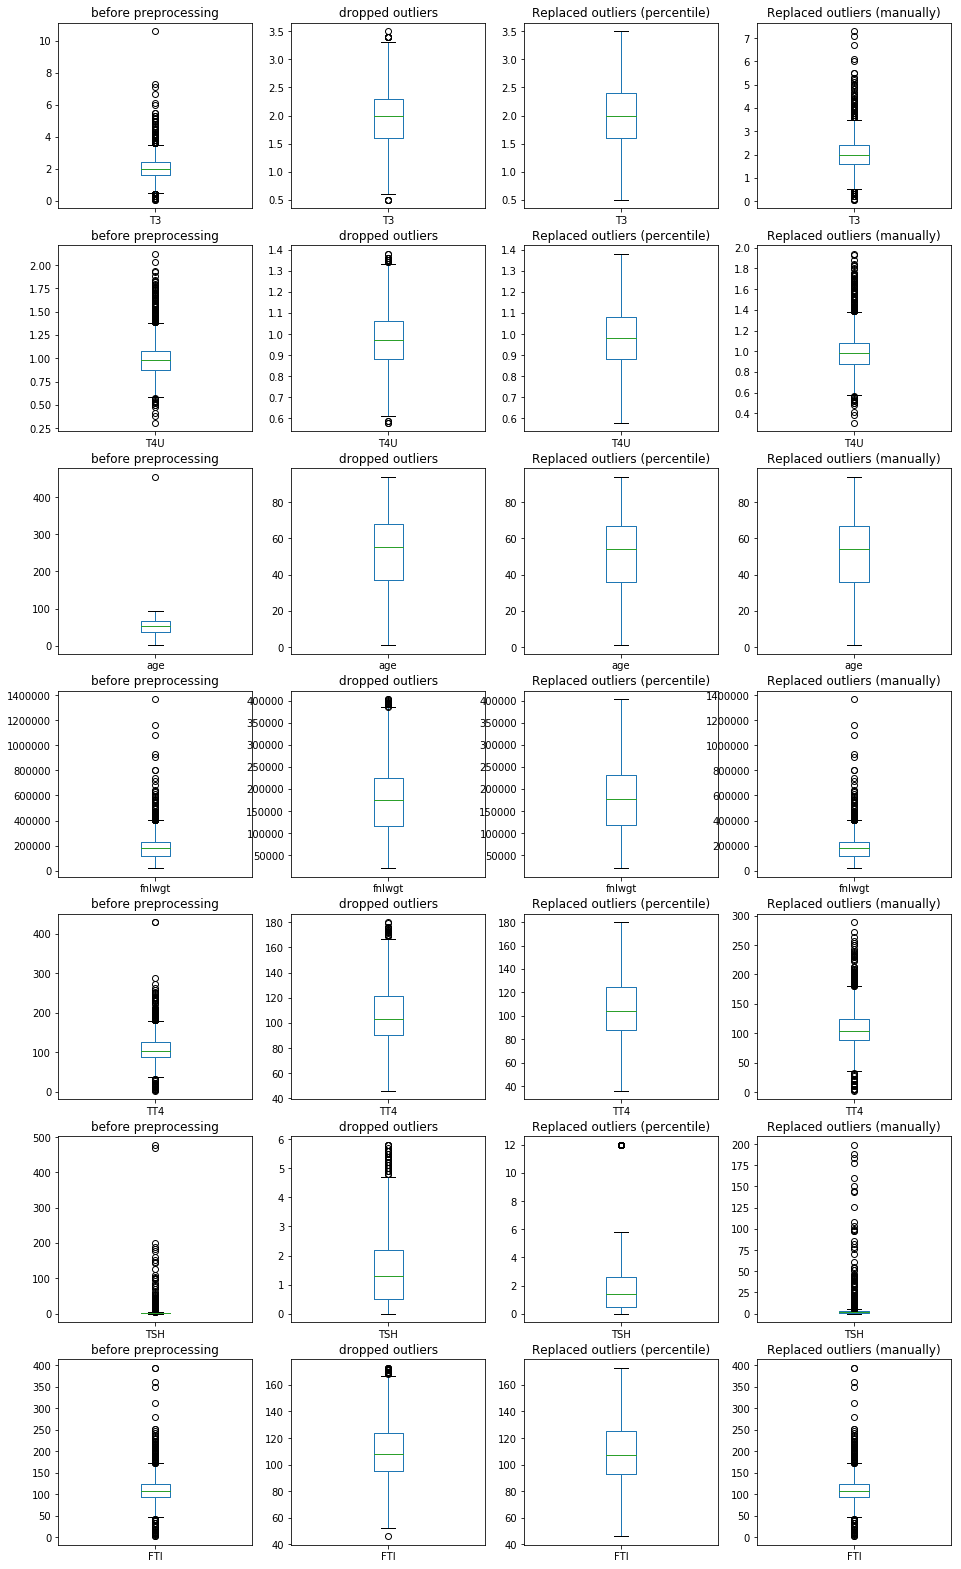

In [81]:
result_train['TT4'] = pd.to_numeric(result_train.TT4, errors='coerce')
result_train['TSH'] = pd.to_numeric(result_train.TSH, errors='coerce')
result_train['FTI'] = pd.to_numeric(result_train.FTI, errors='coerce')


# numeric_columns = ['TT4', 'T4U','TSH', 'T3', 'fnlwgt', 'FTI', 'age']
numeric_columns = ['T3','T4U','age', 'fnlwgt', 'TT4','TSH', 'FTI']
titles = ['before preprocessing', 'dropped outliers', 'Replaced outliers (percentile)', 'Replaced outliers (manually)']

ppl = Pipeline([
     ('RemoveExtremes',DropOutliers(numeric_columns))
])
ppl2 = Pipeline([
     ('ReplaceExtremes',ReplaceOutliersWithPercentile(numeric_columns))
])
min_extremes = {'T3': 0, 'T4U' : 0.25,'fnlwgt': 0, 'age' : 0, 'TT4': 0, 'TSH':0, 'FTI':0}
max_extremes = {'T3': 8, 'T4U' : 2, 'fnlwgt': 1400000, 'age' : 100, 'TT4': 400, 'TSH':400, 'FTI': 400}


ppl3 = Pipeline([
     ('ReplaceKnownOutliers',ReplaceOutliers(numeric_columns, min_extremes, max_extremes))
])

test_preprocessing(result_train,numeric_columns,[ppl,ppl2,ppl3],titles)

Odstranenie outlierov na zaklade medzikvartiloveho rozpatia sice zmensilo pocet hodnot, ktore sa javia ako outlieri, ale odstrenenim riadkov sa mohli stratit dolezite informacie, ktore mohli pomoct pri predikcii.

Nahradenim outlierov (na zaklade percentilu) za 5 a 95 percentilnu hodnotu sme dosiahli tiez rozdelenie blizsie normalnemu, ale niektore z hodnot, ktore sa javia, ako vychylene v skutocnosti mozu byt validne, len menej caste pripady, ktore by mohli pomoct pri predikcii a takto ich stracame. 

Tento problem by mohol vyriesit pristup, kde manulane nastavime, ktore hodnoty su vychylene/neralne, ktore nahradime. (Napriklad vek obmedzit od 0 do 100/120 rokov, kedze je velmi nepravdepodobne, ze by clovek zil dlhsie), pre toto riesenie nam ale chyba vacsia znalost domeny, nevieme urcit, ktore hodnoty proteinov su este validne, a ktore uz nie. Vieme pomerne lahko na internete najst rozsah hodnot, co sa pocita este za "normalny", ale je tazke urcit, ze napriklad v pripade chorych ludi aky rozsah tieto hodnoty mozu mat, pricom budu stale validne.

### porovnanie metod normalizacie

porovname vysledky normalizacie ciselnych atributov pomocou Z-score, prirodzeneho logaritmu a boxcox algoritmu

Pre znazormenie sme si vybrali rovnake atributy, ako pri odstranovani outlierov

/home/vajk/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:1029: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


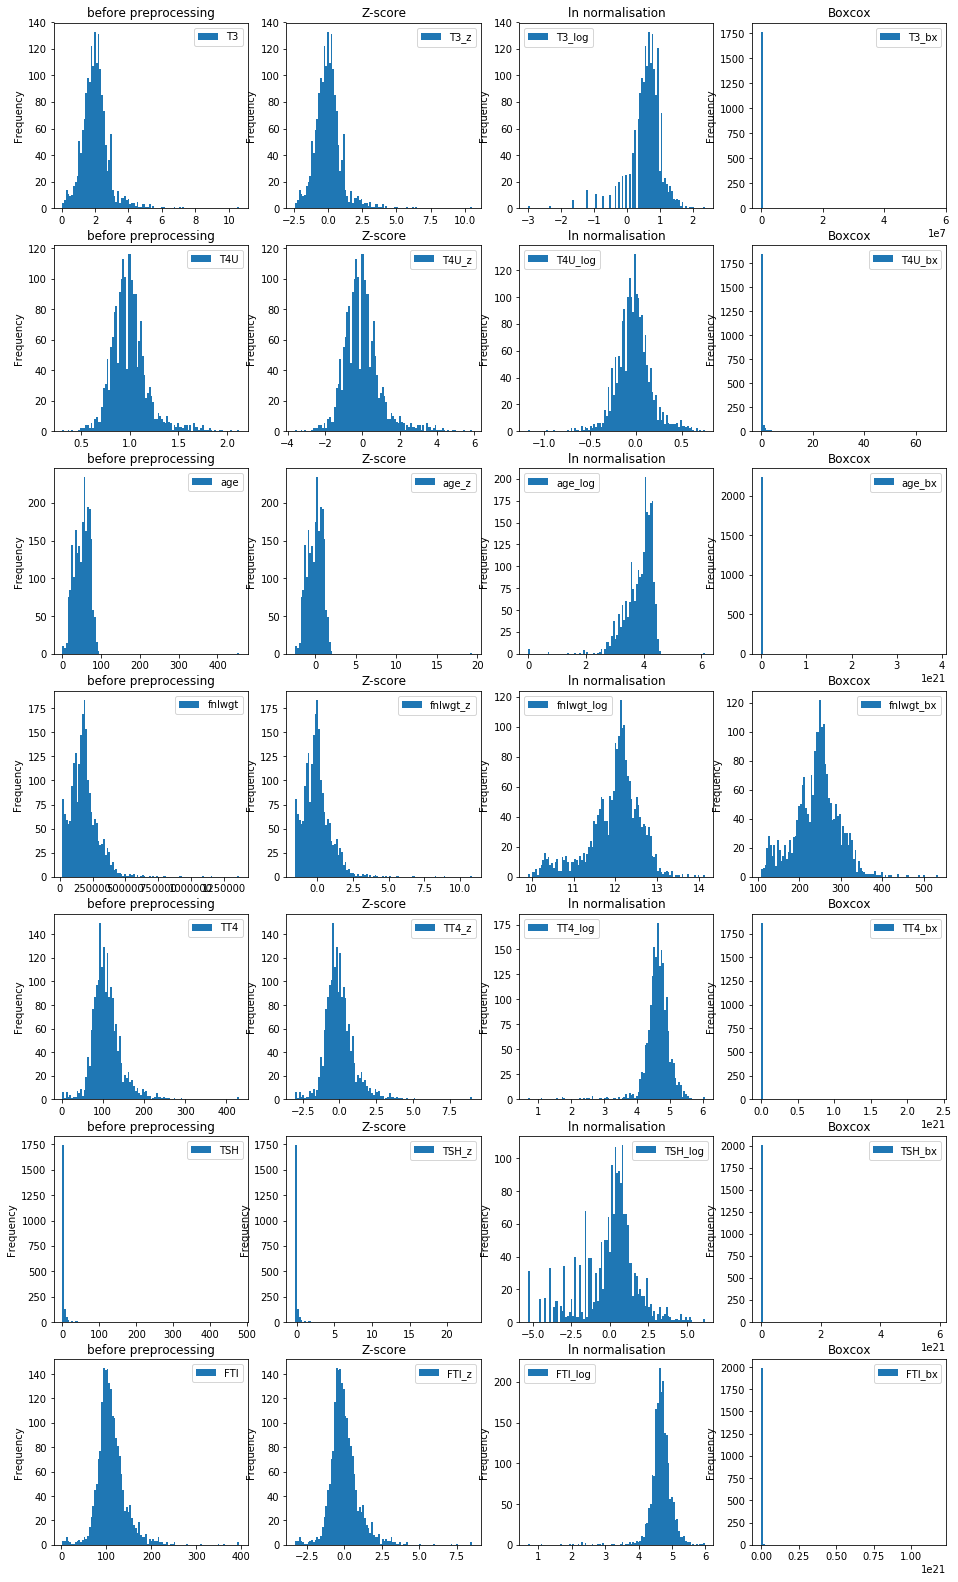

In [82]:
result_train['TT4'] = pd.to_numeric(result_train.TT4, errors='coerce')
result_train['TSH'] = pd.to_numeric(result_train.TSH, errors='coerce')
result_train['FTI'] = pd.to_numeric(result_train.FTI, errors='coerce')


# numeric_columns = ['TT4', 'T4U','TSH', 'T3', 'fnlwgt', 'FTI', 'age']
numeric_columns = ['T3','T4U','age', 'fnlwgt', 'TT4','TSH', 'FTI']
titles = ['before preprocessing', 'Z-score','ln normalisation', 'Boxcox']

ppl = Pipeline([
     ('ZScore',ZScoreNormalization(numeric_columns))
])
ppl2 = Pipeline([
     ('Ln', LogNormalization(numeric_columns))
])
ppl3 = Pipeline([
     ('Boxcox',BoxCoxNormalization(numeric_columns))
])


test_preprocessing(result_train,numeric_columns,[ppl,ppl2,ppl3],titles, sufix=["","_z","_log","_bx"],kind='hist')

Normalizacia pomocou Z-score neovlpyvnilo rozdelenie, ale posunul najfrekventovanejsiu hodnotu do bodu 0.

Transformacia pomocou prirodzeneho logaritmu sposobila, ze rozdelenie hodnot sa viac priblizilo k normalnemu rozdeleniu. V pripade veku ale graf ostal vyrazne vychyleny.

Boxcox normalizacia obmedzila rozsah hodnot na maly interval (voci povodnemu), ale pre hodnoty, ktore boli z maleho rozsahu presunula vacsinu hodnot velmi blizko k 0, pricom zrejme ostalo par outlierov na pravej strane grafov. 

### porovnanie metod doplnania hodnot

#### ciselne atributy
porovname strategie doplnania ciselnych atributov pomocu medianu, priemeru a pomocou linearnej regresie

In [83]:
# SEM TO POROVNAVANIE :D

#### kategoricke atributy

porovname strategie doplnanie kategorickych atributov pomocou najfrekventovanejsej hodnoty a pomocou modelu RandomForest

In [39]:
categorical_columns = ['marital-status','education','native-country','occupation','race','referral source','relationship','sex','sick','tumor','workclass',
'pregnant',	'thyroid surgery', 'I131 treatment',  'psych', 'query hypothyroid']

true_false_cols = ['on antithyroid medication','query hyperthyroid','FTI measured',
                   'lithium','tumor','sick','TT4 measured','goitre','hypopituitary',
                   'TBG measured','TSH measured', 'T3 measured', 'on thyroxine',
                   'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid',
                   'T4U measured', 'thyroid surgery', 'pregnant']

encoder = ce.OneHotEncoder()

ppl = Pipeline([
     ('ExtraxtMedicalInfo',Extraction('medical_info')),
     ('ReplaceFalseCorrect',StringReplacer(true_false_cols,'f','f')),
     ('ReplaceTrueCorrect',StringReplacer(true_false_cols,'t','t')),
    ('ReplaceClassNegative',StringReplacer(['class'],'negativ','negative')),
    ('ReplaceClassIncreased',StringReplacer(['class'],'increase','increased')),
    ('ReplaceClassDecreased',StringReplacer(['class'],'decrease','decreased')),
    ('ReplaceWithModel', ReplaceCategoryNanWithModel('psych',categorical_columns,RandomForestClassifier(n_estimators = 100, 
                                                                                              max_depth = 12, random_state = 8), 
                                                     encoder))
])

model =ppl.fit(result_train)
X_train = ppl.transform(result_train)


psych(accuracy score): 0.9484955885679813


In [40]:
X_train['psych'].isna().value_counts()

False    2237
Name: psych, dtype: int64

In [41]:
X_train.shape

(2237, 48)

In [42]:
result_train.shape


(2237, 38)